# COMPSCI 4AL3: Deepfake Detection Project

## Group 15

This notebook provides the starting structure for our deepfake classification project using PyTorch.

**Project Goal:** Build a model to classify images as "Real" or "Fake".

## 1. Setup: Import Libraries

Import all necessary packages. We'll use `torch` and `torchvision` to build our CNN, `sklearn` for evaluation metrics, and `matplotlib` for plotting results.

In [ ]:
# !pip install kaggle

import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from google.colab import files
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

# Setting global parameters
IMG_SIZE = 128
BATCH_SIZE = 32
IMAGE_SHAPE = (3, IMG_SIZE, IMG_SIZE) # PyTorch format: (Channels, Height, Width)


## 1. Importing Kaggle dataset into Colab environment

In [ ]:
# 1. Create a Kaggle API token (Account Setting > API > Create New Token)
# 2. Run this cell and Upload kaggle.json into Colab or ~/.kaggle folder

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sohaibahmed7","key":"f9932238a635eb5c6b02e8bdbd86eab5"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle


kaggle.json


In [ ]:
!mkdir -p data/deepfake_images


## 2. Downloading dataset

In [ ]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images
!unzip deepfake-and-real-images.zip -d data/deepfake_images


Streaming output truncated to the last 5000 lines.
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5499.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_55.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_550.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5500.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5501.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5502.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5503.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5504.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5505.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5506.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5507.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5508.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5

In [ ]:

!kaggle datasets download -d vijaydevane/deepfake-detection-challenge-dataset-face-images
!unzip -q deepfake-detection-challenge-dataset-face-images.zip -d data/temp_new_data


NEW_DATA_ROOT = Path("data/temp_new_data")
DESTINATION_ROOT = Path("data/deepfake_images/Dataset")

# (70% Train, 15% Validation, 15% Test)
SPLIT_RATIOS = {"Train": 0.7, "Validation": 0.15, "Test": 0.15}

def merge_new_data(source_root, dest_root):
    real_files = []
    fake_files = []

    print("Scanning and categorizing new data...")
    for root, dirs, files in os.walk(source_root):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                file_path = Path(root) / file
                parent_folder = file_path.parent.name.lower()

                if 'real' in parent_folder:
                    real_files.append(file_path)
                elif 'fake' in parent_folder or 'df' in parent_folder:
                    fake_files.append(file_path)

    def distribute_files(file_list, class_name):
        random.shuffle(file_list)
        total = len(file_list)

        train_end = int(total * SPLIT_RATIOS["Train"])
        val_end = train_end + int(total * SPLIT_RATIOS["Validation"])

        splits = {
            "Train": file_list[:train_end],
            "Validation": file_list[train_end:val_end],
            "Test": file_list[val_end:]
        }

        for split_name, files in splits.items():
            target_dir = dest_root / split_name / class_name
            target_dir.mkdir(parents=True, exist_ok=True)

            for src in tqdm(files, leave=False):
                new_name = f"aug_{src.name}"
                shutil.move(str(src), str(target_dir / new_name))

    if real_files: distribute_files(real_files, "Real")
    if fake_files: distribute_files(fake_files, "Fake")

    shutil.rmtree(source_root)

if NEW_DATA_ROOT.exists():
    merge_new_data(NEW_DATA_ROOT, DESTINATION_ROOT)
else:
    print("Second dataset folder not found. Check download/unzip steps.")

Dataset URL: https://www.kaggle.com/datasets/vijaydevane/deepfake-detection-challenge-dataset-face-images
License(s): apache-2.0
  0% 0.00/120M [00:00<?, ?B/s]
100% 120M/120M [00:00<00:00, 1.47GB/s]
Scanning and categorizing new data...


## 3. Data Loading and Preprocessing

We define a `transform` pipeline to resize, crop, convert images to Tensors, and normalize them. Then, we use `ImageFolder` to load the pre-split data and `DataLoader` to create batches.

In [ ]:
# Defining paths for each split
DATA_DIR = Path("/content/data/deepfake_images/Dataset")

train_dir = DATA_DIR / 'Train'
val_dir = DATA_DIR / 'Validation'
test_dir = DATA_DIR / 'Test'

# Transforming/normalize image data (resize, convert to tensor, normalize)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

try:
    # ImageFolder automatically infers class labels ('Fake', 'Real') from subdirectory names.
    image_datasets = {
        'train': datasets.ImageFolder(train_dir, data_transforms['train']),
        'val': datasets.ImageFolder(val_dir, data_transforms['val']),
        'test': datasets.ImageFolder(test_dir, data_transforms['test'])
    }

    # create DataLoaders to group samples from dataset into mini-batches, also shuffles data
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
        'val': DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=2),
        'test': DataLoader(image_datasets['test'], batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    CLASS_NAMES = image_datasets['train'].classes

except FileNotFoundError:
    print("Error: Dataset directory not found.")
    print(f"Please make sure the dataset is at: {DATA_DIR}")
    print("You can download it from: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images/data")

In [ ]:
# Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("--- Final Dataset Statistics ---")
for split in ['train', 'val', 'test']:
    print(f"Split: {split.upper()}")
    print(f"Total Images: {len(image_datasets[split])}")
    # Calculate class balance if possible
    targets = image_datasets[split].targets
    unique, counts = np.unique(targets, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"  - Class {CLASS_NAMES[cls]}: {count} ({count/len(targets)*100:.1f}%)")

Using device: cuda:0
--- Final Dataset Statistics ---
Split: TRAIN
Total Images: 141073
  - Class Fake: 70540 (50.0%)
  - Class Real: 70533 (50.0%)
Split: VAL
Total Images: 39657
  - Class Fake: 19756 (49.8%)
  - Class Real: 19901 (50.2%)
Split: TEST
Total Images: 11135
  - Class Fake: 5608 (50.4%)
  - Class Real: 5527 (49.6%)


## 4. Defining our classifier (CNN Architecture)

In [ ]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32) # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print("BaselineCNN class defined.")

BaselineCNN class defined.


In [ ]:
class DeepfakeClassifierNoDropout(nn.Module):

    def __init__(self):
        super(DeepfakeClassifierNoDropout, self).__init__()

        # Block 1: (3 x 128 x 128) -> (32 x 64 x 64)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2: (32 x 64 x 64) -> (64 x 32 x 32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3: (64 x 32 x 32) -> (128 x 16 x 16)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten the 3D features to 1D vector (Size will be 128 * 16 * 16 = 32768)
        self.flatten = nn.Flatten()

        # Fully-connected layers
        self.fc1 = nn.Linear(in_features=128 * 16 * 16, out_features=128)

        # Output layer
        self.fc2 = nn.Linear(in_features=128, out_features=1) # We only need 1 output node for a binary classification

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)

        return x

print("DeepfakeClassifierNoDropout class defined.")

DeepfakeClassifierNoDropout class defined.


In [ ]:
class DeepfakeClassifier(nn.Module):

    def __init__(self):
        super(DeepfakeClassifier, self).__init__()

        # Block 1: (3 x 128 x 128) -> (32 x 64 x 64)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(p=0.25)

        # Block 2: (32 x 64 x 64) -> (64 x 32 x 32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout2d(p=0.25)

        # Block 3: (64 x 32 x 32) -> (128 x 16 x 16)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout2d(p=0.25)

        # Flatten the 3D features to 1D vector (Size will be 128 * 16 * 16 = 32768)
        self.flatten = nn.Flatten()

        # Fully-connected layers
        self.fc1 = nn.Linear(in_features=128 * 16 * 16, out_features=128)
        self.dropout_fc = nn.Dropout(p=0.5)

        # Output layer
        self.fc2 = nn.Linear(in_features=128, out_features=1) # We only need 1 output node for a binary classification

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)

        x = self.fc2(x)

        return x

print("Final DeepfakeClassifier class defined.")

Final DeepfakeClassifier class defined.


## 5. Training the model

First, we instantiate the model, optimizer, and loss function. Then, we create a function to handle the training and validation loops (1.3).

In [ ]:
# Initialize models, loss functions, and optimizers
models = {
    'DeepfakeClassifier': DeepfakeClassifier().to(device),
    'BaselineCNN': BaselineCNN().to(device),
    'DeepfakeClassifierNoDropout': DeepfakeClassifierNoDropout().to(device)
}

optimizers = {}
criterions = {}

for name, model_instance in models.items():
    optimizers[name] = optim.Adam(model_instance.parameters(), lr=0.001)
    criterions[name] = nn.BCEWithLogitsLoss() # Binary Cross Entropy

print("All models, optimizers, and criterions initialized.")

All models, optimizers, and criterions initialized.


In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    start_time = time.time()

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # print(len(dataloaders[phase]))
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.float().view(-1, 1).to(device)

                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    preds = (torch.sigmoid(outputs) > 0.5).float()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model)
    return model, history


In [ ]:
EPOCHS = 5

if 'dataloaders' in locals() and 'models' in locals() and 'criterions' in locals() and 'optimizers' in locals():
    all_models_history = {}
    for model_name, model_instance in models.items():
        print(f"\n{'='*20}\nTraining {model_name}\n{'='*20}")
        trained_model, history = train_model(model_instance, criterions[model_name], optimizers[model_name], num_epochs=EPOCHS)
        models[model_name] = trained_model # Update the model in the dictionary with the trained one
        all_models_history[model_name] = history
        print(f"Training of {model_name} completed.")

    history = all_models_history # Assign the combined history for plotting the last trained model
    print("All models trained. History is stored in 'all_models_history'.")
else:
    print("Skipping training because data, models, criterions or optimizers were not loaded.")


Training DeepfakeClassifier
Epoch 1/5
----------
train Loss: 0.3694 Acc: 0.8279
val Loss: 0.2518 Acc: 0.8867

Epoch 2/5
----------
train Loss: 0.2327 Acc: 0.9031
val Loss: 0.2103 Acc: 0.9071

Epoch 3/5
----------
train Loss: 0.2015 Acc: 0.9165
val Loss: 0.1887 Acc: 0.9209

Epoch 4/5
----------
train Loss: 0.1875 Acc: 0.9233
val Loss: 0.1903 Acc: 0.9182

Epoch 5/5
----------
train Loss: 0.1757 Acc: 0.9289
val Loss: 0.1766 Acc: 0.9248

Training complete in 25m 19s
Best val Acc: 0.924805
Training of DeepfakeClassifier completed.

Training BaselineCNN
Epoch 1/5
----------
train Loss: 0.2967 Acc: 0.8665
val Loss: 0.2727 Acc: 0.8783

Epoch 2/5
----------
train Loss: 0.1570 Acc: 0.9350
val Loss: 0.2411 Acc: 0.8990

Epoch 3/5
----------
train Loss: 0.1028 Acc: 0.9579
val Loss: 0.2776 Acc: 0.8946

Epoch 4/5
----------
train Loss: 0.0677 Acc: 0.9727
val Loss: 0.3160 Acc: 0.9055

Epoch 5/5
----------
train Loss: 0.0483 Acc: 0.9809
val Loss: 0.3393 Acc: 0.9124

Training complete in 24m 24s
Best v

## 6. Results and Evaluation

Plotting our training history and print the final classification metrics from the test set.

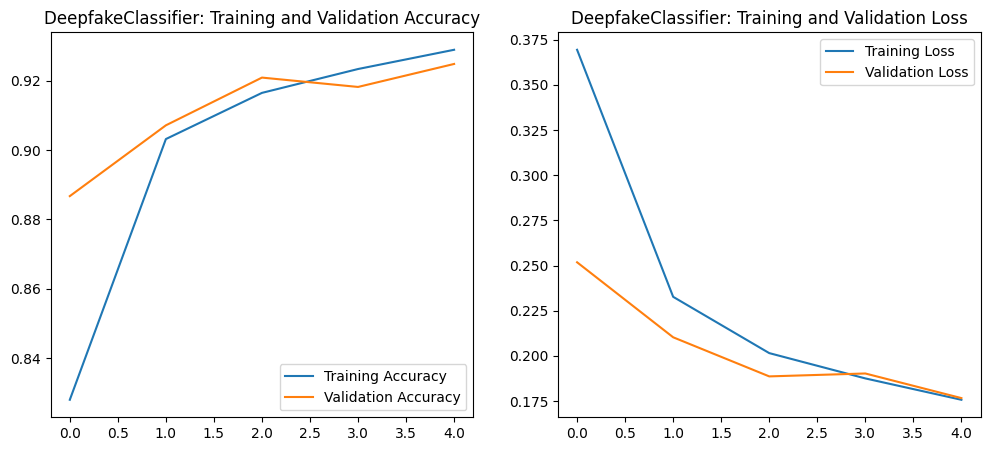

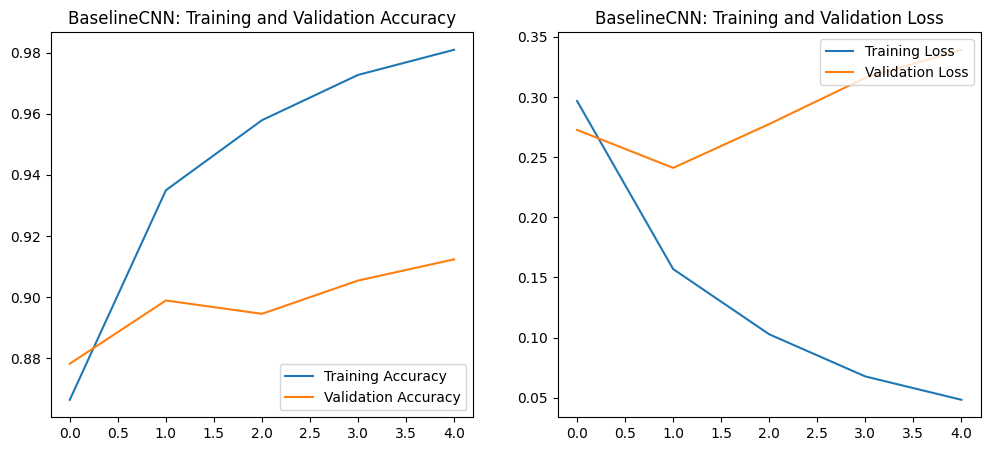

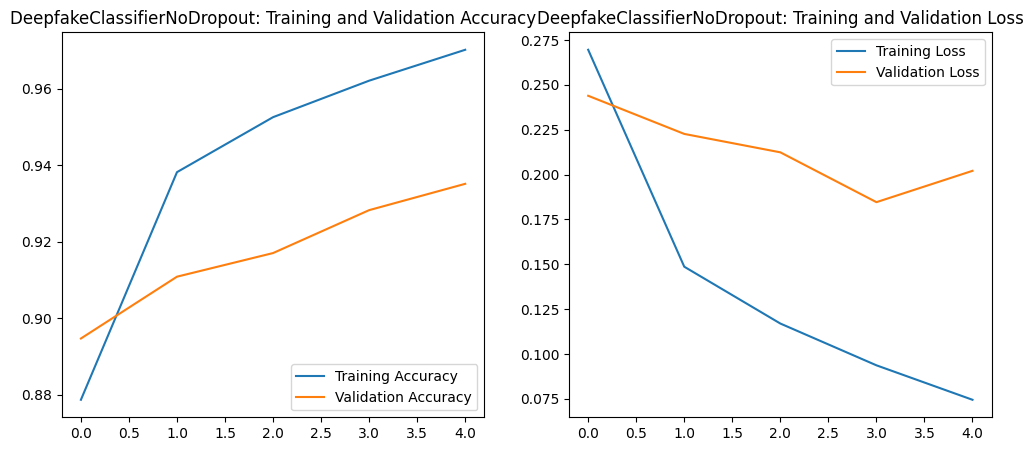

In [ ]:
def plot_training_history(all_histories):
    for model_name, history in all_histories.items():
        acc = [h for h in history['train_acc']]
        val_acc = [h for h in history['val_acc']]
        loss = [h for h in history['train_loss']]
        val_loss = [h for h in history['val_loss']]

        epochs_range = range(len(acc))

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title(f'{model_name}: Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title(f'{model_name}: Training and Validation Loss')
        plt.show()

if 'all_models_history' in locals():
    plot_training_history(all_models_history)
else:
    print("No training history found. Please train models first.")

### 6.1 Final Evaluation on Test Set

Now we use the unseen test set to get our final, unbiased metrics.


Evaluating DeepfakeClassifier on Test Set

--- Classification Report ---
              precision    recall  f1-score   support

        Fake       0.92      0.88      0.90      5608
        Real       0.88      0.92      0.90      5527

    accuracy                           0.90     11135
   macro avg       0.90      0.90      0.90     11135
weighted avg       0.90      0.90      0.90     11135


--- Confusion Matrix ---


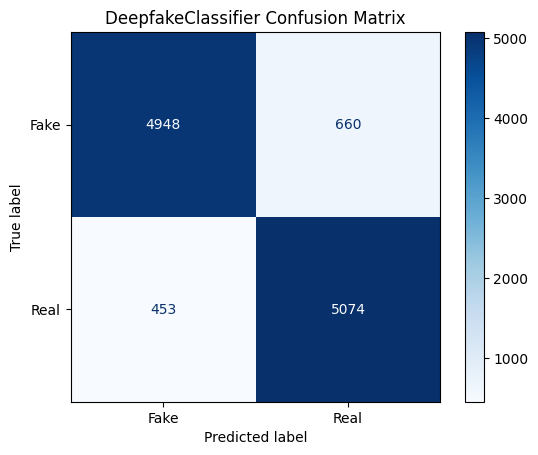


Evaluating BaselineCNN on Test Set

--- Classification Report ---
              precision    recall  f1-score   support

        Fake       0.85      0.86      0.85      5608
        Real       0.85      0.85      0.85      5527

    accuracy                           0.85     11135
   macro avg       0.85      0.85      0.85     11135
weighted avg       0.85      0.85      0.85     11135


--- Confusion Matrix ---


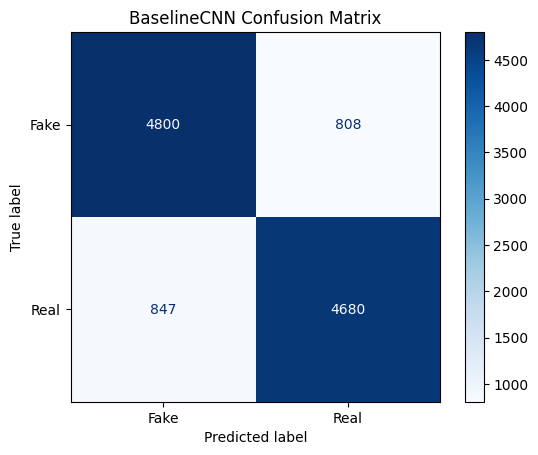


Evaluating DeepfakeClassifierNoDropout on Test Set

--- Classification Report ---
              precision    recall  f1-score   support

        Fake       0.86      0.92      0.89      5608
        Real       0.91      0.85      0.88      5527

    accuracy                           0.89     11135
   macro avg       0.89      0.88      0.89     11135
weighted avg       0.89      0.89      0.89     11135


--- Confusion Matrix ---


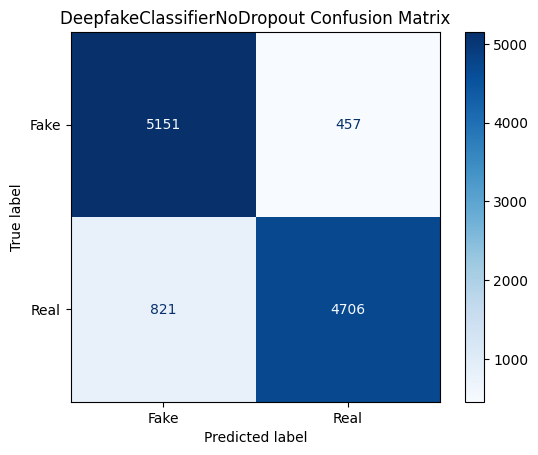

In [ ]:
def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds).flatten()

if 'dataloaders' in locals() and 'models' in locals():
    for model_name, model_instance in models.items():
        print(f"\n{'='*20}\nEvaluating {model_name} on Test Set\n{'='*20}")
        y_true, y_pred = get_predictions(model_instance, dataloaders['test'])

        print("\n--- Classification Report ---")
        print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'{model_name} Confusion Matrix')
        plt.show()

else:
    print("Skipping evaluation because data or models are not available.")